In [1]:
#Schegletov Denis DS
#d.shchegletov@innopolis.university
#ML Assignment 2
import cv2
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
#if you use google collab

# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#prefix = "/content/drive/MyDrive/a2/" # path to image folder for google colab
#prefix is path to images folder
prefix = ""

In [4]:
#4
mypath = "images"
mypath = prefix + mypath
#files named: 001_** - 103_**
files = []
for i in range(1,104):
    start = str(i)
    #1->001, 10->010, 100->100
    start = (3 - len(start)) * "0" + start
    #files has structure:[[001_01.png, 001_02.png, ...], [002_01.png, 002_02.png, ...], ...]
    files.append([os.path.join(mypath, f) for f in sorted(os.listdir(mypath)) if os.path.isfile(os.path.join(mypath, f)) and f.startswith(start) and f.endswith("png")])

for line in range(len(files)):
    for im in range(len(files[line])):
      #reading files using string path to these files
        files[line][im] = cv2.imread(files[line][im])

for line in range(len(files)):
    for im in range(len(files[line])):
      #converting to gray scale
        files[line][im] = cv2.cvtColor(files[line][im], cv2.COLOR_BGR2GRAY)

for line in range(len(files)):
    for im in range(len(files[line])):
      #normalizing images
        files[line][im] = files[line][im]/255

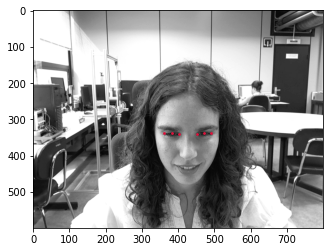

In [5]:
lines = open(prefix + "labels/001_image_labels.txt").readlines()
#reading positions of points
tokens = lines[0].strip().split("	")
points = tokens[1:]
point1 = points[0:2]
point2 = points[2:4]
point3 = points[4:6]
point4 = points[6:8]
point5 = points[8:10]
point6 = points[10:12]

point1 = [int(float(i)) for i in point1]
point2 = [int(float(i)) for i in point2]
point3 = [int(float(i)) for i in point3]
point4 = [int(float(i)) for i in point4]
point5 = [int(float(i)) for i in point5]
point6 = [int(float(i)) for i in point6]
#reading first image and converting to gray scale
image = cv2.imread(prefix + f"images/{tokens[0]}")
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#showing image in gray scale format and drawing points
plt.imshow(gray_image, cmap="gray")
plt.scatter([point1[0], point2[0],point3[0],point4[0],point5[0], point6[0]], [point1[1], point2[1],point3[1],point4[1],point5[1], point6[1]], c="crimson", s=3)

In [6]:
def crop(image, i, j):
  #doing the same as above but with all images
    start = str(i+1)
    start = (3-len(start)) * "0" + start
    lines = open(prefix + f"labels/{start}_image_labels.txt").readlines()
    
    
    tokens = lines[j].strip().split("\t")
    points = tokens[1:]
    point1 = points[0:2]#external left eye
    point2 = points[2:4]#center left eye
    point3 = points[4:6]#internal left eye
    
    point4 = points[6:8]#internal right eye
    point5 = points[8:10]#center right eye
    point6 = points[10:12]#external right eye
    
    point1 = [int(float(i)) for i in point1]
    point3 = [int(float(i)) for i in point3]#left eye corners
    
    point4 = [int(float(i)) for i in point4]
    point6 = [int(float(i)) for i in point6]#right eye corners
    
    point2 = [int(float(i)) for i in point2]
    point5 = [int(float(i)) for i in point5]#centers
    
    #distance between corners
    weight = abs(point3[0] - point1[0])
    #left corner out of external and internal corners(image can be reversed, so for left eye it doesn't mean that external corner will always be the left)
    x = min(point3[0], point1[0])
    #hald of distance between corners
    w = weight//2
    #padding is fraction of distance, that will be taken from all sides of eye image
    padding = int(weight * 0.1)
    #calculating y center
    y = sum([point3[1], point1[1]])//2
    #cropping in such a way, so that for x we take external corner, internal corner and taking padding from left and right
    #for y we take center as center of image and taking half of x distance between corners and padding from top and bottom
    #cropped image will be square
    left_crop_img = image[y - padding - w : y + padding + w,
                          x - padding : x + padding + weight]
    #resizing image to 48x48
    left_resized_img = cv2.resize(left_crop_img, (48,48))
    #translating position of center
    left_center = [(point2[0] - x + padding)*48/(weight+2*padding), (point2[1] - y + padding + w)*48/(weight+2*padding)]#new left center
    
    #same for other eye
    weight = abs(point6[0] - point4[0])
    x = min(point6[0], point4[0])
    w = weight//2
    padding = int(weight * 0.1)
    y = sum([point6[1], point4[1]])//2
    
    right_crop_img = image[y - padding - w : y + padding + w,
                           x - padding : x + padding + weight]
    right_resized_img = cv2.resize(right_crop_img, (48,48))

    right_center = [(point5[0] - x + padding)*48/(weight+2*padding), (point5[1] - y + padding + w)*48/(weight+2*padding)]#new right center
    
    
    return [{"img":left_resized_img, "center":left_center}, {"img":right_resized_img, "center":right_center}]

In [7]:
eyes = []
#making datasets of eyes out of image
for line in range(len(files)):
    eyes.append([])
    for im in range(len(files[line])):
        eyes[line].append(crop(files[line][im], line, im))

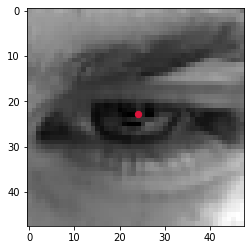

In [8]:
plt.imshow(eyes[0][0][0]["img"], cmap="gray")
plt.scatter(eyes[0][0][0]["center"][0], eyes[0][0][0]["center"][1], c="crimson", s=40)

In [10]:
X = []
Y = []
#making X and Y samples
#Y is image with 1 pixel with iris 
for line in range(len(files)):
    for im in range(len(files[line])):
        for eye in eyes[line][im]:
            X.append(eye["img"])
            y = np.zeros((48,48))
            center = eye["center"]
            change_x = [int(center[0]) - 1, int(center[0]), int(center[0]) + 1]
            change_y = [int(center[1]) - 1, int(center[1]), int(center[1]) + 1]
            for i in change_x:
              for j in change_y:
                y[i][j] = 1
            Y.append(y)

In [11]:
from sklearn.model_selection import train_test_split
#splitting samples
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.8, random_state=0)

In [12]:
#use GPU for collab
%tensorflow_version 2.x
import tensorflow
device_name = tensorflow.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Input, Conv2DTranspose, UpSampling2D, concatenate
from tensorflow.keras import backend as K

Found GPU at: /device:GPU:0


In [13]:
def make_model(activation="relu", optimizer="adam", loss="mse"):
    input_layer = Input(shape=(48,48,1))
    #(n+2p-f)/s+1=output for conv2d
    #(48+2*1-3)/1+1=48
    conv1 = Conv2D(filters=64, kernel_size=3, padding="same", activation=activation, input_shape=(48, 48, 1) )(input_layer)
    #(48+2*1-4)/2+1=24
    conv2 = Conv2D(filters=128, kernel_size=4, strides=2, padding="same", activation=activation, input_shape=(48, 48, 64) )(conv1)
    #(24-2)/2+1=12
    conv3 = Conv2D(filters=256, kernel_size=2, strides=2, activation=activation, input_shape=(24, 24, 128) )(conv2)
    #upsample (12, 12, 256) -> (48, 48, 256)
    upsample = UpSampling2D(size=(4, 4), interpolation="bilinear")(conv3)
    #make filters smaller 256->64
    #(48-1)/1+1=48
    conv_reshape = Conv2D(filters=64, kernel_size=1, activation=activation, input_shape=(48, 48, 256) )(upsample)
    #concatenate gray layer and orange layer(resized, in my case I also use convolution layer to reduce filters) from given architecture
    conc = concatenate([conv_reshape, conv1], axis=3)
    #(48+2*2-5)/1+1=48
    conv4 = Conv2D(filters=64, kernel_size=5, padding="same", activation=activation, input_shape=(48, 48, 128) )(conc)
    #(48+2-3)/1+1=48
    conv5 = Conv2D(filters=1, kernel_size=3, padding="same", input_shape=(48, 48, 64), name="base")(conv4)
    #(n-1)*s+f-2p=output for conv2dtranspose
    #(12-1)*2+2-2*0=24
    aux1 = Conv2DTranspose(filters=128, kernel_size=2, strides=2, activation=activation, input_shape=(12, 12, 256) )(conv3)
    #(24-1)*2+4-2*1=48
    aux2 = Conv2DTranspose(filters=64, kernel_size=4, padding="same", strides=2, activation=activation, input_shape=(24, 24, 128) )(aux1)
    #(48-1)*1+3-2*1 = 48
    aux3 = Conv2DTranspose(filters=1, kernel_size=3, padding="same", activation=activation, input_shape=(48, 48, 64), name="aux")(aux2)
    
    model = Model(inputs=input_layer, outputs=[conv5, aux3])
    #https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
    def dice_score(y_true, y_pred):
        smooth = 1
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    model.compile(loss=loss, optimizer=optimizer, metrics=dice_score)
    return model

In [14]:
#initialization of model
model = make_model()
print(model.summary())
#function for reshaping input sets
make_set = lambda t: np.array(t)[..., None]
x_train_processed = make_set(x_train)
y_train_processed = make_set(y_train)
x_test_processed = make_set(x_test)
y_test_processed = make_set(y_test)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 64)   640         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 24, 24, 128)  131200      ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 12, 12, 256)  131328      ['conv2d_1[0][0]']               
                                                                                              

In [15]:
model.fit(x=x_train_processed, y={"base":y_train_processed, "aux":x_train_processed}, epochs=200)

Epoch 1/200
16/16 [==============================] - 13s 120ms/step - loss: 0.0529 - base_loss: 0.0075 - aux_loss: 0.0454 - base_dice_score: 0.0030 - aux_dice_score: 0.2912
Epoch 2/200
16/16 [==============================] - 1s 79ms/step - loss: 0.0117 - base_loss: 0.0039 - aux_loss: 0.0078 - base_dice_score: 0.0074 - aux_dice_score: 0.3970
Epoch 3/200
16/16 [==============================] - 1s 78ms/step - loss: 0.0066 - base_loss: 0.0039 - aux_loss: 0.0027 - base_dice_score: 0.0058 - aux_dice_score: 0.4080
Epoch 4/200
16/16 [==============================] - 1s 77ms/step - loss: 0.0057 - base_loss: 0.0039 - aux_loss: 0.0018 - base_dice_score: 0.0064 - aux_dice_score: 0.4071
Epoch 5/200
16/16 [==============================] - 1s 78ms/step - loss: 0.0048 - base_loss: 0.0039 - aux_loss: 9.6291e-04 - base_dice_score: 0.0133 - aux_dice_score: 0.4118
Epoch 6/200
16/16 [==============================] - 1s 78ms/step - loss: 0.0044 - base_loss: 0.0038 - aux_loss: 5.6462e-04 - base_dice_sco

In [16]:
#evaluating mode and predicting result
y_pred = model.predict(x_test_processed[:10])
model.evaluate(x_test_processed, {"base":y_test_processed, "aux":x_test_processed})

62/62 [==============================] - 3s 39ms/step - loss: 0.0037 - base_loss: 0.0037 - aux_loss: 4.3171e-05 - base_dice_score: 0.2339 - aux_dice_score: 0.4149


[0.003740484593436122,
 0.0036973124369978905,
 4.317110506235622e-05,
 0.2339409440755844,
 0.41489169001579285]

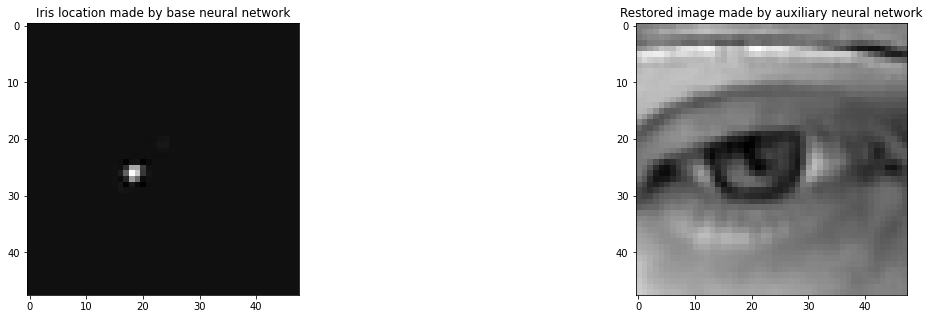

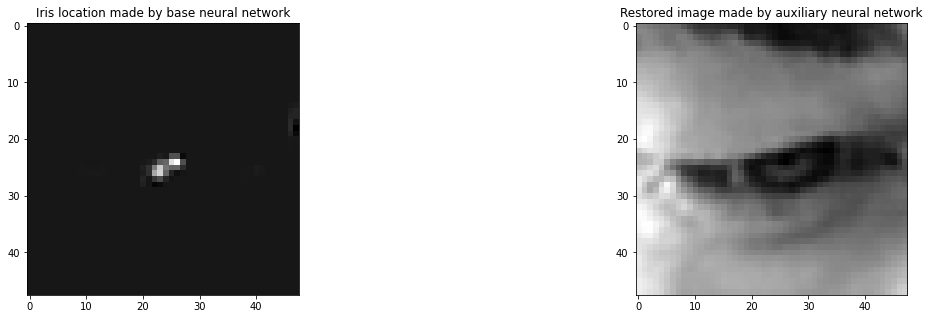

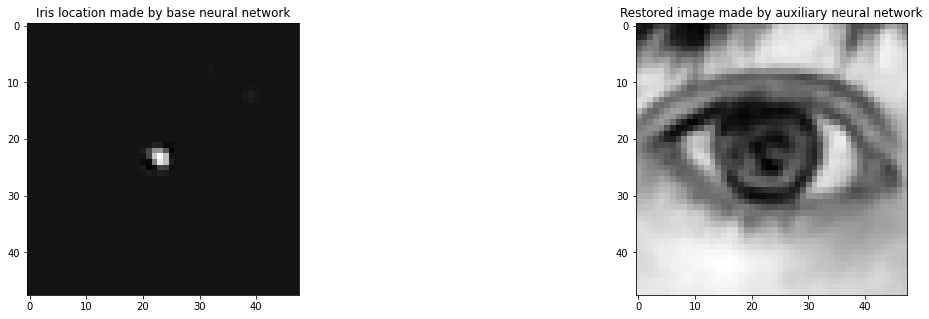

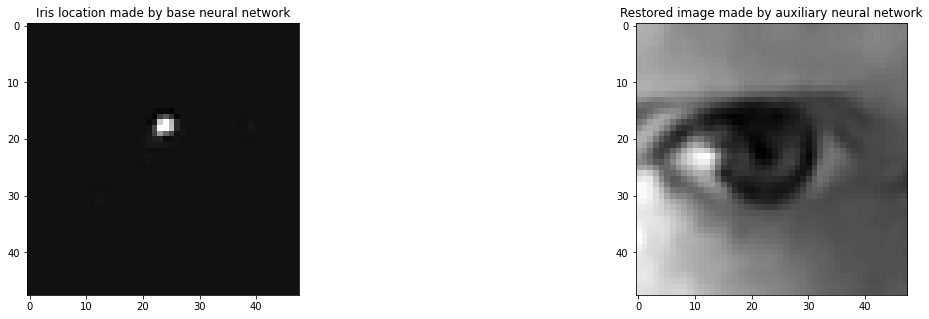

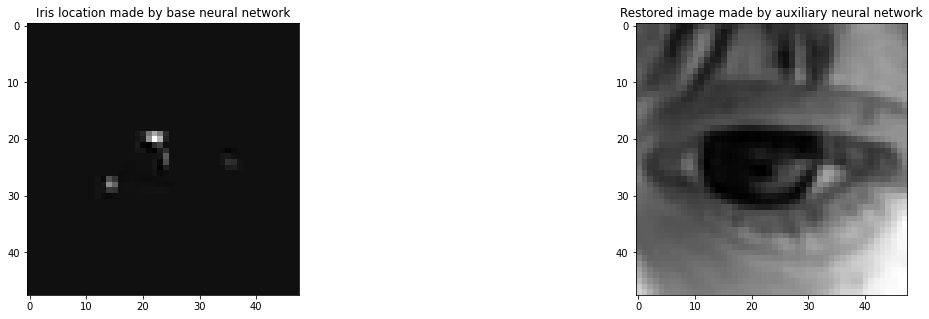

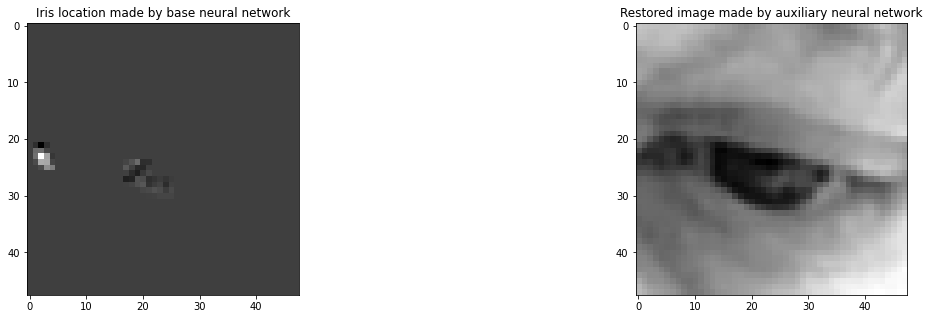

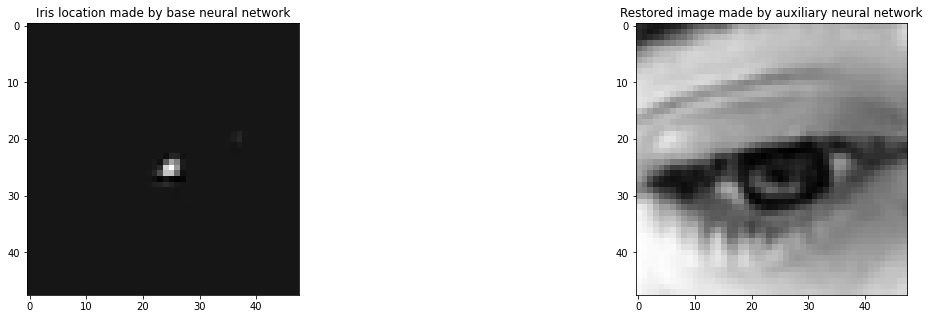

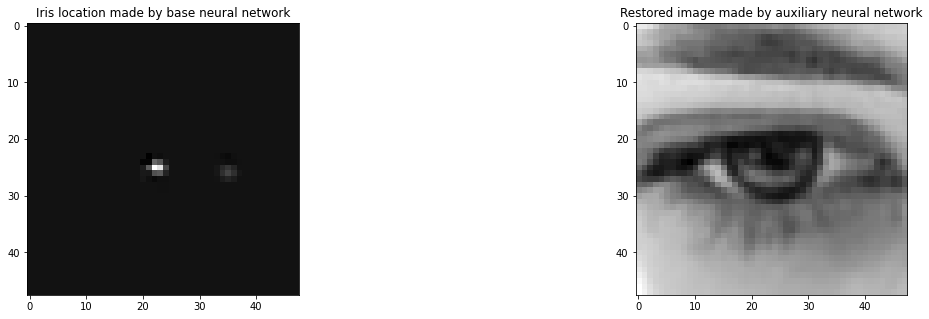

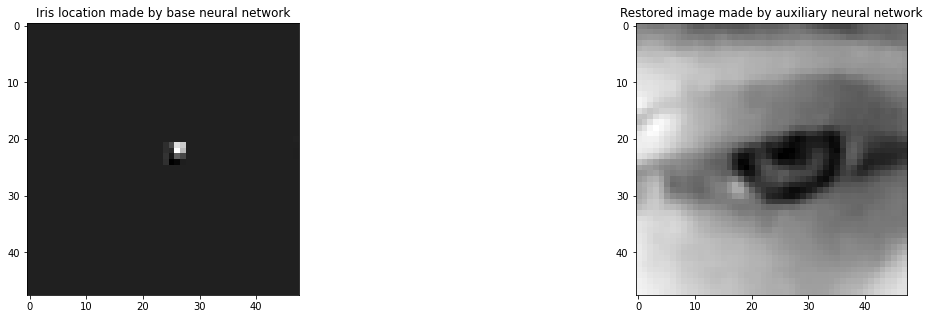

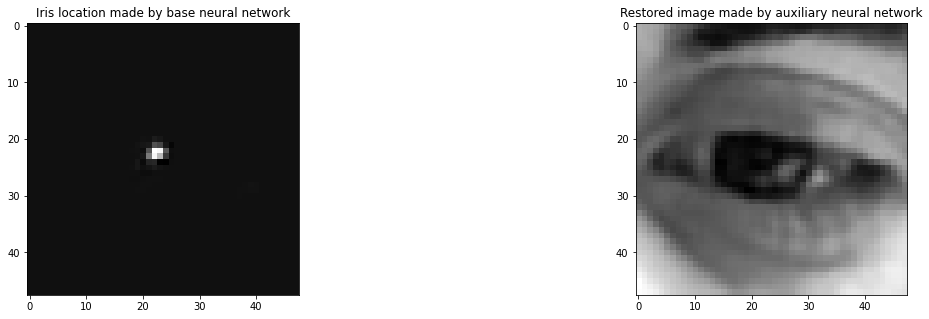

In [17]:
#printing resulting images
base = y_pred[0]
aux = y_pred[1]
for i in range(base.shape[0]):
  iris = base[i].reshape((48,48))
  img = aux[i].reshape((48,48))

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

  ax1.imshow(iris, cmap='gray')
  ax1.title.set_text('Iris location made by base neural network')
  ax1.plot()
  ax2.imshow(img, cmap='gray')
  ax2.title.set_text('Restored image made by auxiliary neural network')
  ax2.plot()
  plt.show()

In [18]:
#make_model
optimizers = ['sgd', 'adam', 'adamax', 'rmsprop']
losses = ['mse', 'mae']
activations = ['tanh', 'relu', 'sigmoid']
epoch = 100
#grid search
metrics_grid_search_cv = []
for opt in optimizers:
  for loss in losses:
    for activation in activations:
        model = make_model(activation=activation, loss=loss, optimizer=opt)
        model.fit(x_train_processed,{"base":y_train_processed, "aux":x_train_processed}, epochs=epoch)
        metrics = model.evaluate(x_test_processed,{"base":y_test_processed, "aux":x_test_processed})
        #save result in list
        metrics_grid_search_cv.append({"metrics":metrics, "epoch":epoch, "activation":activation, "loss": loss, "optimizer":opt})

Epoch 1/100
16/16 [==============================] - 3s 84ms/step - loss: 0.0827 - base_loss: 0.0046 - aux_loss: 0.0781 - base_dice_score: 0.0023 - aux_dice_score: 0.1709
Epoch 2/100
16/16 [==============================] - 1s 80ms/step - loss: 0.0365 - base_loss: 0.0044 - aux_loss: 0.0322 - base_dice_score: 0.0036 - aux_dice_score: 0.2969
Epoch 3/100
16/16 [==============================] - 1s 81ms/step - loss: 0.0304 - base_loss: 0.0043 - aux_loss: 0.0261 - base_dice_score: 0.0055 - aux_dice_score: 0.3264
Epoch 4/100
16/16 [==============================] - 1s 80ms/step - loss: 0.0294 - base_loss: 0.0042 - aux_loss: 0.0252 - base_dice_score: 0.0066 - aux_dice_score: 0.3359
Epoch 5/100
16/16 [==============================] - 1s 80ms/step - loss: 0.0290 - base_loss: 0.0042 - aux_loss: 0.0249 - base_dice_score: 0.0075 - aux_dice_score: 0.3405
Epoch 6/100
16/16 [==============================] - 1s 80ms/step - loss: 0.0288 - base_loss: 0.0041 - aux_loss: 0.0247 - base_dice_score: 0.0081

In [19]:
sorted(metrics_grid_search_cv, key=lambda x: x["metrics"][1])#sorting by base loss function(mse or mae) for base CNN
#best parameters are: relu, mse, adamax(adam is second one)

[{'activation': 'relu',
  'epoch': 100,
  'loss': 'mse',
  'metrics': [0.003307898296043277,
   0.0032555314246565104,
   5.236639844952151e-05,
   0.21087677776813507,
   0.41545793414115906],
  'optimizer': 'adamax'},
 {'activation': 'relu',
  'epoch': 100,
  'loss': 'mse',
  'metrics': [0.003913272172212601,
   0.0034738590475171804,
   0.0004394127754494548,
   0.1898932307958603,
   0.42375314235687256],
  'optimizer': 'rmsprop'},
 {'activation': 'tanh',
  'epoch': 100,
  'loss': 'mse',
  'metrics': [0.004321252927184105,
   0.0037944186478853226,
   0.000526833871845156,
   0.029023561626672745,
   0.41327789425849915],
  'optimizer': 'rmsprop'},
 {'activation': 'tanh',
  'epoch': 100,
  'loss': 'mse',
  'metrics': [0.0038999354001134634,
   0.003819475183263421,
   8.046036964515224e-05,
   0.022442268207669258,
   0.4146226644515991],
  'optimizer': 'adam'},
 {'activation': 'tanh',
  'epoch': 100,
  'loss': 'mse',
  'metrics': [0.00425040302798152,
   0.0038473911117762327,
   

In [ ]:
#3
#read csv file
data = pd.read_csv("android_traffic.csv")
data.head() 

,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,source_app_packets.1,dns_query_times,type
0,36,6,3,3911,0,39,33,5100,4140,39,3,benign
1,117,0,9,23514,0,128,107,26248,24358,128,11,benign
2,196,0,6,24151,0,205,214,163887,24867,205,9,benign
3,6,0,1,889,0,7,6,819,975,7,1,benign
4,6,0,1,882,0,7,6,819,968,7,1,benign


In [ ]:
#impute data from "type" column->map benign to 0, malicious to 1 to make a model predict type correctly
data["type"] = data["type"].map({"benign": 0, "malicious": 1})
data.head()

,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,source_app_packets.1,dns_query_times,type
0,36,6,3,3911,0,39,33,5100,4140,39,3,0
1,117,0,9,23514,0,128,107,26248,24358,128,11,0
2,196,0,6,24151,0,205,214,163887,24867,205,9,0
3,6,0,1,889,0,7,6,819,975,7,1,0
4,6,0,1,882,0,7,6,819,968,7,1,0


In [ ]:
from sklearn.model_selection import train_test_split

#choosing columns for X and Y
X = data.drop(columns=["type"])
y = data["type"]
#splitting data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=0)

In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

#initialising classifiers
random_forest = RandomForestClassifier(max_depth=15)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=15))
bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=15))

In [ ]:
from sklearn.model_selection import GridSearchCV

#parameters are taken from here https://docs.google.com/spreadsheets/d/1wK8v95tFyHC07NBwODW4ejKOXUsTYTCjtk2kReUUKiM/edit#gid=0
ada_parameters = {"n_estimators": [30, 40, 50, 60, 70],
              "base_estimator__max_features": ["log2", "sqrt"],
              "base_estimator__min_impurity_decrease": np.logspace(-6,-9, num=13)
             }
bagging_parameters = {"n_estimators": [30, 40, 50, 60, 70],
              "base_estimator__max_features": ["log2", "sqrt"],
              "base_estimator__min_impurity_decrease": np.logspace(-6,-9, num=13)
             }
random_forest_parameters = {"n_estimators": [30, 40, 50, 60, 70],
              "max_features": ["log2", "sqrt"],
              "min_impurity_decrease": np.logspace(-6,-9, num=13)
             }
#initialising grid searches for every classifier(I make classifier split into 3 folds)
grid_search_random_forest = GridSearchCV(random_forest, random_forest_parameters, cv=3)
grid_search_ada = GridSearchCV(ada, ada_parameters, cv=3)
grid_search_bagging = GridSearchCV(bagging, bagging_parameters, cv=3)
grid_searches = [grid_search_random_forest, grid_search_ada, grid_search_bagging]

In [ ]:
best_params = []
#fine-tuning parameters using grid searches

#order is random_forest->ada->bagging everywhere
for grid_search in grid_searches:
    grid_search.fit(x_train, y_train)
    best_params.append(grid_search.best_params_)
    print(grid_search.__class__.__name__+": ", grid_search.best_params_)

[{'max_features': 'log2',
  'min_impurity_decrease': 1.7782794100389227e-07,
  'n_estimators': 30},
 {'base_estimator__max_features': 'log2',
  'base_estimator__min_impurity_decrease': 3.162277660168379e-08,
  'n_estimators': 60},
 {'base_estimator__max_features': 'sqrt',
  'base_estimator__min_impurity_decrease': 1e-08,
  'n_estimators': 40}]

In [ ]:
from sklearn.metrics import accuracy_score
#initialising classifiers with best parameters and max_depth=15
random_forest = RandomForestClassifier(max_depth=15)
random_forest.set_params(**best_params[0])

ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=15))
ada.set_params(**best_params[1])

bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=15))
bagging.set_params(**best_params[2])

estimators = [random_forest, ada, bagging]
for est in estimators:
    #checking accuracy of model using test set
    est.fit(x_train, y_train)
    y_pred = est.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"accuracy of {est.__class__.__name__} is {accuracy}")
    #Bagging performs best
    #bagging will have deeper base learners because it reduces variance by averaging and voting classifier predictions, so overall structure will not be as overfit.
    #because of this, bagging classifier tree will grow, without overfitting much.
    #random forest is mostly the same as bagging, accuracy difference is insignificant.
    #ada is just eliminate weaknesses, so it dropes deep trees 

accuracy of RandomForestClassifier is 0.8540471637985978
accuracy of AdaBoostClassifier is 0.8185149776927979
accuracy of BaggingClassifier is 0.8542065009560229


In [ ]:
from sklearn.model_selection import cross_val_score

max_depths = range(5,26)

cv_scores = {"random_forest": [], "ada": [], "bagging":[]}

for depth in max_depths:
    #fine-tuning classifiers using max_depth parameter
    random_forest = RandomForestClassifier(max_depth=depth)
    random_forest.set_params(**best_params[0])
    cv_scores["random_forest"].append(cross_val_score(random_forest, x_train, y_train, cv=3))
    
    ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=depth))
    ada.set_params(**best_params[1])
    cv_scores["ada"].append(cross_val_score(ada, x_train, y_train, cv=3))
    
    bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=depth))
    bagging.set_params(**best_params[2])
    cv_scores["bagging"].append(cross_val_score(bagging, x_train, y_train, cv=3))

In [ ]:
#cv_scores contains 2D array, because I used cv=3 parameter in cross_val_score
#to make it singular accuracy score I take average of it by y axis
#example [[0.1, 0.2, 0.3], [0.4, 0.5, 0.6]] -> [0.2, 0.5]
cv_scores["random_forest"] = np.mean(cv_scores["random_forest"], axis=1)
cv_scores["ada"] = np.mean(cv_scores["ada"], axis=1)
cv_scores["bagging"] = np.mean(cv_scores["bagging"], axis=1)

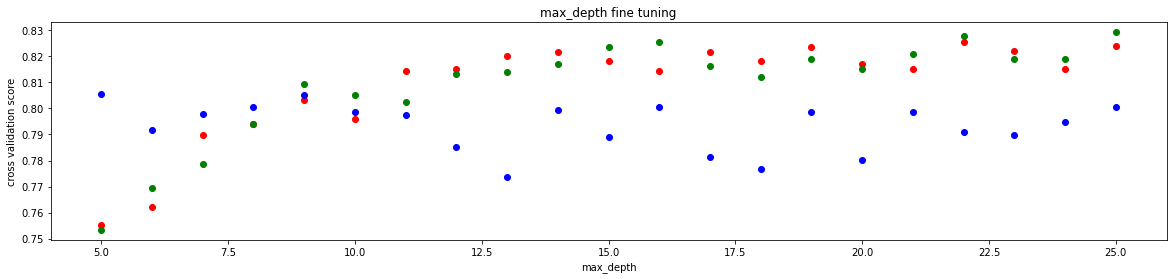

In [ ]:
#ploting graph
#red=random_forest
#blue=ada
#green=bagging
plt.figure(figsize=(20,4))
plt.scatter(max_depths, cv_scores["random_forest"], c="r")
plt.scatter(max_depths, cv_scores["ada"], c="b")
plt.scatter(max_depths, cv_scores["bagging"], c="g")
plt.title("max_depth fine-tuning")
plt.xlabel("max_depth")
plt.ylabel("cross validation score")
plt.show()
#answer from 4 question is agree with this plot(ada(blue) is almost the same, whereas random forest(red) and bagging(green) are training without overfitting much)

In [ ]:
#best max_depth for every classifier
random_forest_max_depth =  5 + np.argmax(cv_scores["random_forest"])
ada_max_depth =  5 + np.argmax(cv_scores["ada"])
bagging_max_depth =  5 + np.argmax(cv_scores["bagging"])
print(random_forest_max_depth, ada_max_depth, bagging_max_depth)

22 5 25
